In [40]:
from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import itertools
%matplotlib inline

### Tree-Based Nonparametric Priors

##### Mondrian Processes

A *Mondrian Process* is a prior over kd-trees.  

In [41]:
def draw_Mondrian(theta_space, budget=5):
    return draw_Mondrian_at_t(theta_space, 0, budget)
    
def draw_Mondrian_at_t(theta_space, t, budget):
    dists = theta_space[:,1] - theta_space[:,0]
    lin_dim = np.sum(dists)
    T = np.random.exponential(scale=1./lin_dim)
    
    if t+T > budget: 
        return (None, None, None) #(t, t+T, None, None, None, None)
    
    d = np.argmax(np.random.multinomial(n=1, pvals=dists/lin_dim))
    x = np.random.uniform(low=theta_space[d,0], high=theta_space[d,1])
    
    theta_left = np.copy(theta_space)
    theta_left[d][1] = x 
    M_left = draw_Mondrian_at_t(theta_left, t+T, budget)
    
    theta_right = np.copy(theta_space)
    theta_right[d][0] = x 
    M_right = draw_Mondrian_at_t(theta_right, t+T, budget)
    
    return (theta_space, M_left, M_right)

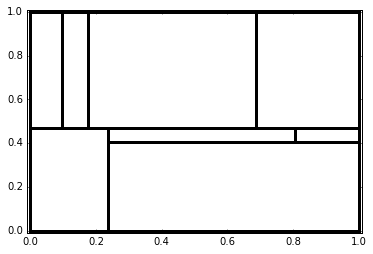

In [125]:
Z = np.array([[0.,1.],[0.,1.]])
parts = draw_Mondrian(Z, 4)

plt.figure()

def print_partitions(p):
    if not isinstance(p[0], np.ndarray): return 
    
    plt.plot([p[0][0,0], p[0][0,0]], [p[0][1,0], p[0][1,1]], '-k', linewidth=3)
    plt.plot([p[0][0,1], p[0][0,1]], [p[0][1,0], p[0][1,1]], '-k', linewidth=3)
    plt.plot([p[0][0,0], p[0][0,1]], [p[0][1,0], p[0][1,0]], '-k', linewidth=3)
    plt.plot([p[0][0,0], p[0][0,1]], [p[0][1,1], p[0][1,1]], '-k', linewidth=3)
    
    if isinstance(p[1], tuple): print_partitions(p[1])
    if isinstance(p[2], tuple): print_partitions(p[2])

print_partitions(parts)

plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.show()

Lastly, we can run an example to see if the weights change accordingly.  First, let's make a function to visualize the mixture.  Plot the (spherical) Gaussians such that their transparency corresponds to the mixture weight.

In [ ]:
def plot_mixture(x, pi, mu_arr, cov_arr):
    color_iter = itertools.cycle(['r', 'b', 'c', 'g'])
    fig = plt.figure(0)
    ax = fig.add_subplot(111, aspect='equal')
    for i, (weight, mean, covar, color) in enumerate(zip(pi, mu_arr, cov_arr, color_iter)):
        e = matplotlib.patches.Ellipse(mean, 5*covar[0,0], 5*covar[1,1], 180)
        ax.add_artist(e)
        e.set_clip_box(ax.bbox)
        e.set_alpha(weight)
        e.set_facecolor(color)
    ax.scatter([x[0]], [x[1]], s=100, color='k', marker='x', label="data")
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ax.legend()
    plt.show()

Define the mixture and one data point $x$...

In [ ]:
# define mixture weights
pi = np.array([.95, .05])

# define base dists.
mu_s = [np.array([-5., -5.]), np.array([5., 5.])]
cov_s = [np.array([[1., 0.], [0., 1.]]), np.array([[1., 0.], [0., 1.]])]

# data
x = np.array([5., 5.])

# plot mixture
plot_mixture(x, pi, mu_s, cov_s)